# Project No 5. Conc Request ML

In [260]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from datetime import datetime
sample_submission = pd.read_csv('sample_submission.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Define kinds of values

In [261]:
df_train['sample'] = 1 
df_test['sample'] = 0  
df_test['default'] = 0 
#joint
data = df_test.append(df_train, sort=False).reset_index(drop=True)
data["app_date"] = data["app_date"].apply(lambda x: datetime.strptime(x, '%d%b%Y').timestamp()).astype(int)
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,1395439200,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,1390514400,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,1395525600,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,1391378400,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,1391464800,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,1393884000,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,1,0
110144,76821,1395612000,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,1,0
110145,103695,1398114000,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,1,0
110146,861,1388786400,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,1


# The features

In [262]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# Change sex cat from letter to number 

In [263]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


# Fitting number for column sex

In [264]:
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
for column in cat_cols:
    data[column] = label_encoder.fit_transform(data[column])
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,1395439200,1,1,29,1,1,0,0,-2.271884,3,3,0,1,50000,0,3,0,0,0
1,17527,1390514400,3,0,39,0,0,5,0,-1.504999,2,3,0,1,5000,3,2,0,0,0
2,75683,1395525600,4,1,50,1,1,0,0,-1.691339,1,3,0,1,30000,0,2,1,0,0
3,26883,1391378400,3,1,56,0,0,0,0,-2.374182,1,2,0,1,17000,0,2,0,0,0
4,28862,1391464800,1,0,38,0,0,0,0,-2.487502,0,6,1,2,120000,0,2,0,0,0


In [265]:
# Let's look at the default probability distribution:
pd.crosstab(df_train.work_address, df_train.default, normalize='index')*100

default,0,1
work_address,,
1,92.584593,7.415407
2,89.749342,10.250658
3,85.204297,14.795703


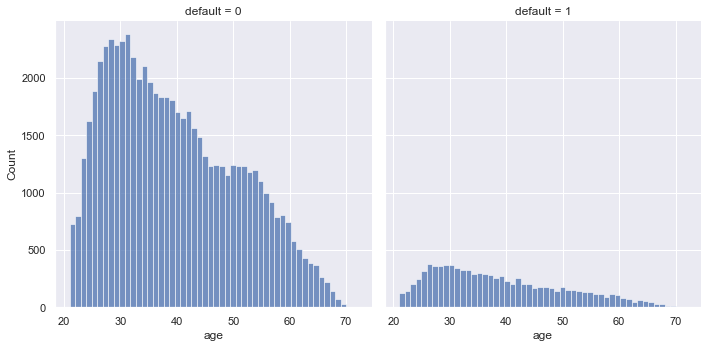

In [266]:
# Let's look at the age distribution by default:
sns.displot(df_train, x="age", col="default", bins=52)

<AxesSubplot:xlabel='default', ylabel='age'>

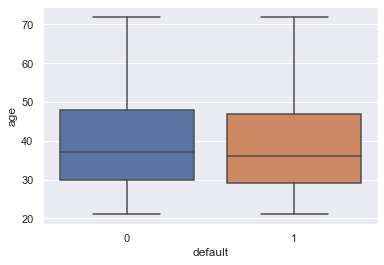

In [267]:
sns.boxplot(x='default',y='age',data=data)

# Test part

In [268]:
df_train = data.query('sample == 1').drop(['sample'], axis=1)
df_test = data.query('sample == 0').drop(['sample', 'default'], axis=1)
y = df_train['default'].values  # the target
X = df_train.drop(['default'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 18), (14760, 18), (59039,), (14760,))

In [269]:
logreg = LogisticRegression(solver='liblinear', C = 0.01, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [270]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[12933     0]
 [ 1827     0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12933
           1       0.00      0.00      0.00      1827

    accuracy                           0.88     14760
   macro avg       0.44      0.50      0.47     14760
weighted avg       0.77      0.88      0.82     14760



Text(0.5, 257.44, 'Predicted label')

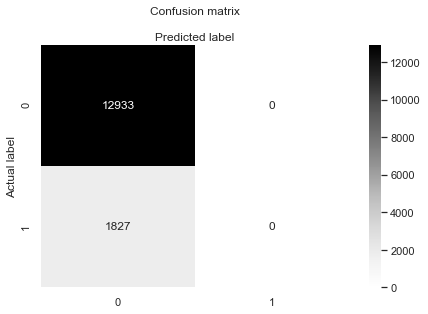

In [271]:
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Greys" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

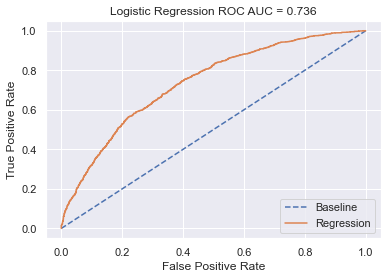

In [302]:
proba = logreg.predict_proba(X_test)
proba = proba[:,1]

fpr, tpr, threshold = roc_curve(y_test, proba)
roc_auc = roc_auc_score(y_test, proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Well, for conclision, it's awful result, therefore we'll continue to clean our df

# Outliers cleaning & working

<AxesSubplot:xlabel='income', ylabel='Density'>

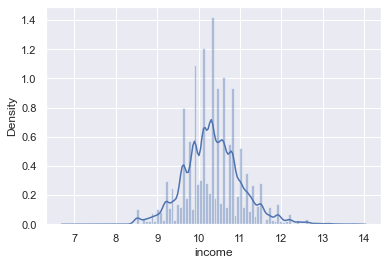

In [272]:
df_train['income'] = np.log(df_train['income'] + 1)
df_test['income'] = np.log(df_test['income'] + 1)

sns.distplot(df_train.income, bins=100)

In [273]:
def borders(col):
    q1 = col.quantile(.25)
    q3 = col.quantile(.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return low, high

In [274]:
def check_outliers(col, data):
    """
    Determines the presence of outliers in the feature col of the dataset data using the interquantile range method
    """
    
    low, high = borders(data[col])
    outliers = ((data[col] < low) | (data[col] > high)).sum()
    
    if not outliers:
        print(f"In feature '{col}' no outliers\n")
        return

    print(f"Amount of outliers in feature '{col}': {outliers}")
    print(f"Borders of outliers: [{low}, {high}]\n")

In [275]:
def features_to_drop(df, cut):
    """
    Based on the correlation coefficients, determines the features that should be removed
    
    df - Dataframe
    cut - correlation coefficient threshold
    """

    corr_mtx = df.corr()
    avg_corr = corr_mtx.mean(axis=1) 
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(bool)) 
    drop = [] 

    for row in range(len(up)-1): 
        for col in range(row + 1, len(up)): 
            if(abs(corr_mtx.iloc[row, col]) > cut):
               
                if(abs(avg_corr.iloc[row]) > abs(avg_corr.iloc[col])):
                    drop.append(row)
                else:
                    drop.append(col)
                
    dropcols_names = list(df.columns[list(set(drop))])
    if dropcols_names:
        return dropcols_names
    print("No strongly correlated variables")

In [276]:
def calc_f_score(y_true, y_pred):
    """
    the higher f_score 
    """
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)
    denom = precision + recall 
    denom[denom == 0] = -1
    f_score = (2 * precision * recall / denom)[:-1] 
    return f_score, threshold

In [277]:
for col in num_cols:
    check_outliers(col, data)

In feature 'age' no outliers

Amount of outliers in feature 'score_bki': 518
Borders of outliers: [-3.299251946250001, -0.5290698762499992]

Amount of outliers in feature 'decline_app_cnt': 18677
Borders of outliers: [0.0, 0.0]

Amount of outliers in feature 'score_bki': 518
Borders of outliers: [-3.299251946250001, -0.5290698762499992]

Amount of outliers in feature 'bki_request_cnt': 2636
Borders of outliers: [-4.5, 7.5]

Amount of outliers in feature 'income': 7000
Borders of outliers: [-22000.0, 90000.0]



In [278]:
def get_boxplot(DF, column, parameter):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.boxplot(x=column, y=parameter,
                data=DF.loc[DF.loc[:, column].isin(
                    DF.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.grid()
    plt.show()

<Figure size 432x288 with 0 Axes>

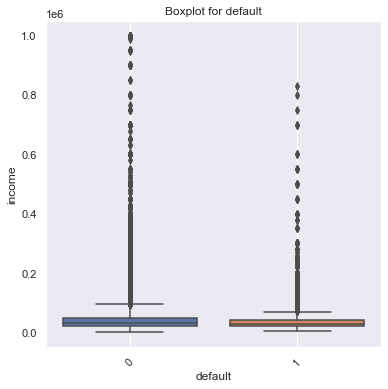

<Figure size 432x288 with 0 Axes>

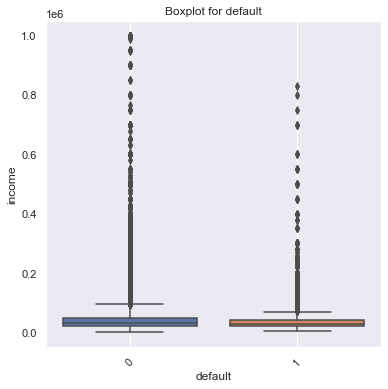

<Figure size 432x288 with 0 Axes>

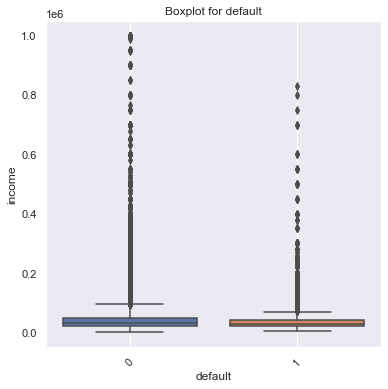

<Figure size 432x288 with 0 Axes>

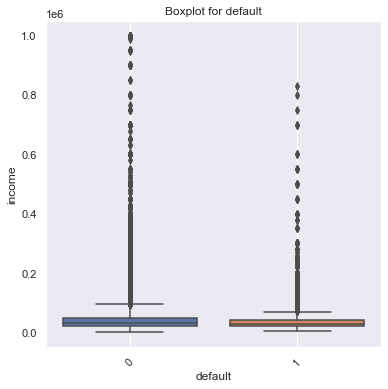

<Figure size 432x288 with 0 Axes>

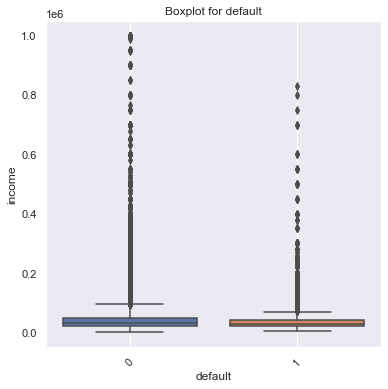

<Figure size 432x288 with 0 Axes>

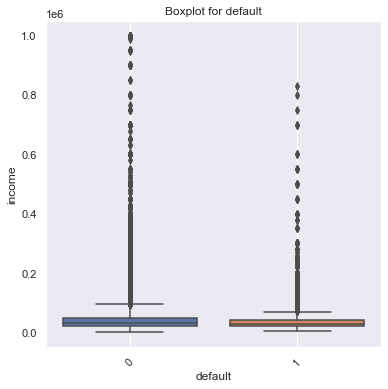

In [279]:
for num in num_cols:
    plt.figure()
    #sns.distplot(data[col][data[col] > 0].dropna(), kde = False, rug=False)
    #plt.title(col)
    #plt.show()
    get_boxplot(data, 'default', col)

In [280]:
dac = data["decline_app_cnt"]
dac.mean(), dac.max()

(0.2732051421723499, 33)

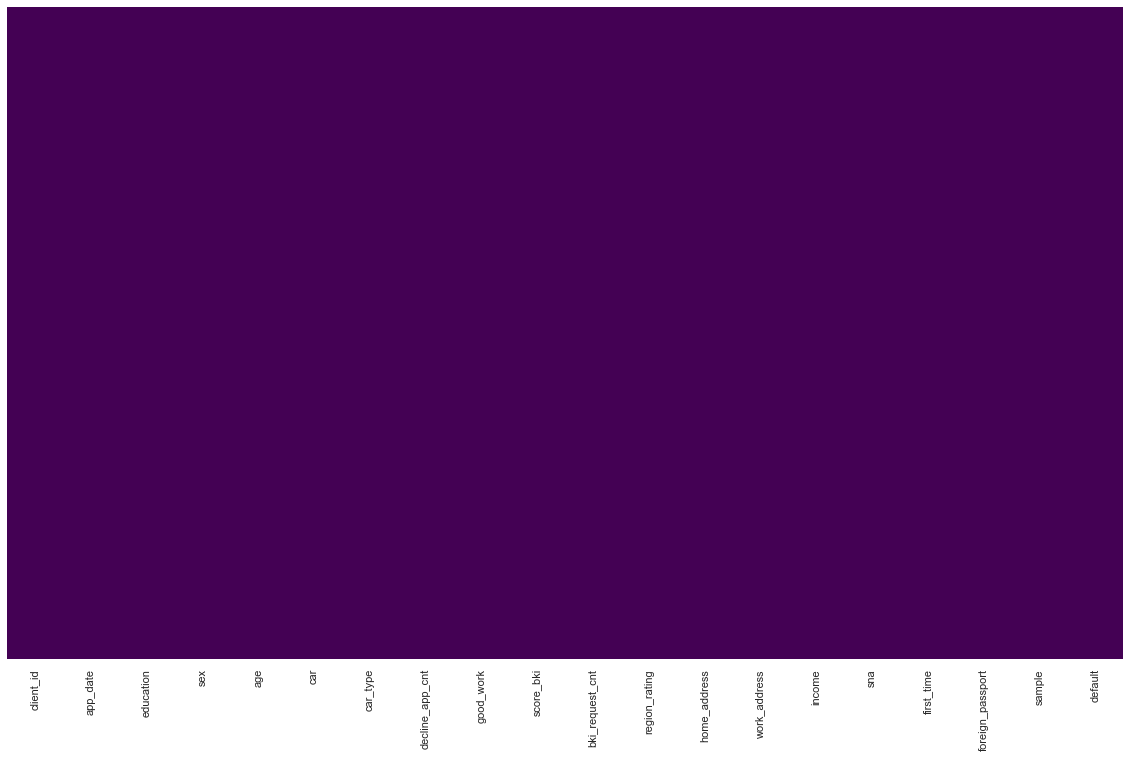

In [281]:
# looking for empty cells
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<AxesSubplot:>

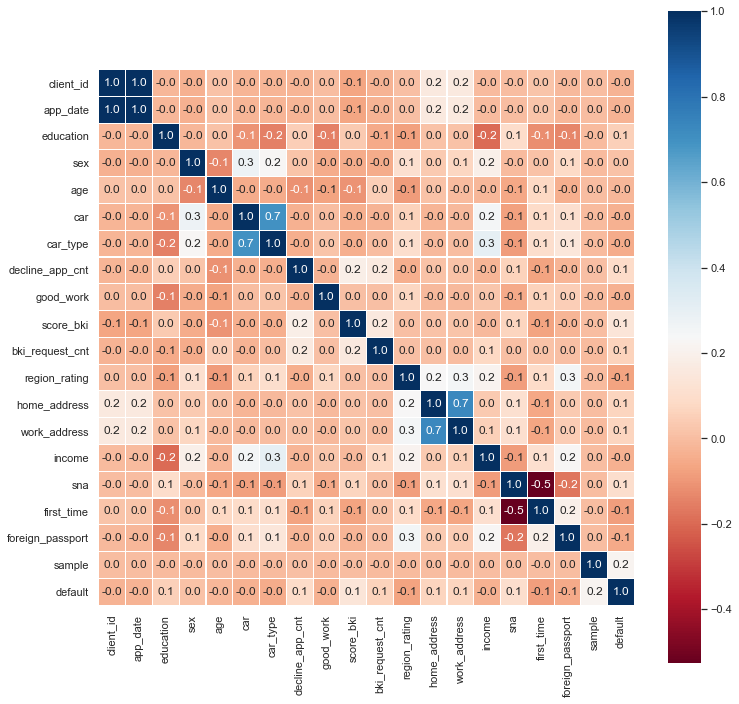

In [282]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(data.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

# Data: 'client' & 'app_date', 'car' & 'car_type' are not necessary, so I will delete it

In [283]:
# because of high correlation going to delete home_add & work_add, car, car_type & client_id & app_date also
data.drop(['car', 'car_type', 'client_id', 'app_date', 'home_address', 'work_address'], axis = 1, inplace=True)

<AxesSubplot:>

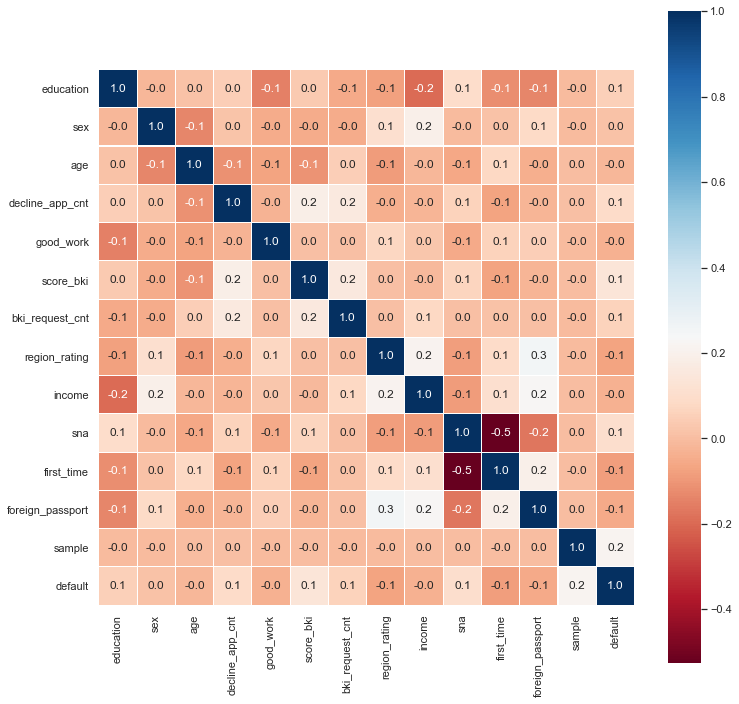

In [284]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(data.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [285]:
# take out outliers
for x in ['decline_app_cnt']:
    q75,q25 = np.percentile(data.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    data.loc[data[x] < min,x] = np.nan
    data.loc[data[x] > max,x] = np.nan

In [286]:
for col in num_cols:
    check_outliers(col, data)

In feature 'age' no outliers

Amount of outliers in feature 'score_bki': 518
Borders of outliers: [-3.299251946250001, -0.5290698762499992]

In feature 'decline_app_cnt' no outliers

Amount of outliers in feature 'score_bki': 518
Borders of outliers: [-3.299251946250001, -0.5290698762499992]

Amount of outliers in feature 'bki_request_cnt': 2636
Borders of outliers: [-4.5, 7.5]

Amount of outliers in feature 'income': 7000
Borders of outliers: [-22000.0, 90000.0]



# Adapt the NAN cells to the most common number throgh 'MODE'

In [287]:
ed_mode = data.income.mode().item()
data.income = data.income.fillna(ed_mode)

In [288]:
ed_mode_2 = data.decline_app_cnt.mode().item()
data.decline_app_cnt = data.decline_app_cnt.fillna(ed_mode_2)

In [289]:
ed_mode_3 = data.score_bki.mode().item()
data.score_bki = data.score_bki.fillna(ed_mode_3)

In [290]:
ed_mode_4 = data.sna.mode().item()
data.sna = data.sna.fillna(ed_mode_4)

In [291]:
ed_mode_5 = data.bki_request_cnt.mode().item()
data.bki_request_cnt = data.bki_request_cnt.fillna(ed_mode_5)

# I'll check if there are still any anomalies:))))

In [292]:
data.isna().sum()

education           0
sex                 0
age                 0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

In [293]:
#The function of creating a model on a given set of parameters
def LogReg (parameters):
    model = LogisticRegression(C = parameters['C'],
                            class_weight = parameters['class_weight'],
                            dual = parameters['dual'],
                            fit_intercept = parameters['fit_intercept'],
                            intercept_scaling = parameters['intercept_scaling'],
                            l1_ratio = parameters['l1_ratio'],
                            max_iter = parameters['max_iter'],
                            multi_class = parameters['multi_class'],
                            n_jobs = parameters['n_jobs'],
                            penalty = parameters['penalty'],  
                            random_state = parameters['random_state'],
                            solver = parameters['solver'], 
                            tol = parameters['tol'],
                            verbose = parameters['verbose'],
                            warm_start = parameters['warm_start'])
    return model

In [294]:
# Adopt hyperparameters for model - Special Thanks to statistic scientists:)))) 
import warnings
warnings.filterwarnings("ignore")
iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(logreg, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
logreg = gridsearch.best_estimator_

#type parametrs
best_parameters = logreg.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))


	C: 0.01
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l1'
	random_state: None
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False


# We create a model with optimal parameters and train

In [295]:
logreg = LogReg(best_parameters)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [296]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[8666 4267]
 [ 601 1226]]
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.22      0.67      0.33      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.73     14760



Text(0.5, 257.44, 'Predicted label')

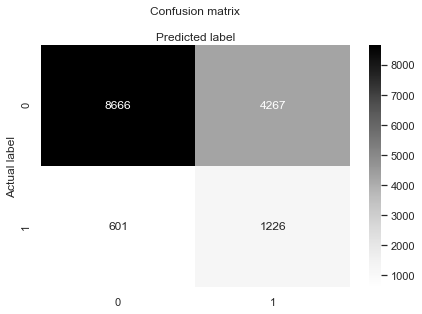

In [297]:
cnf_matrix = confusion_matrix(y_test, y_pred)

class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Greys" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [298]:
y_balance = slice_balance['default'].values  
X_balance = slice_balance.drop(['default'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance, test_size=0.2, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [299]:
predict_submission = logreg.predict(df_test)

In [300]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


(<AxesSubplot:ylabel='default'>,)

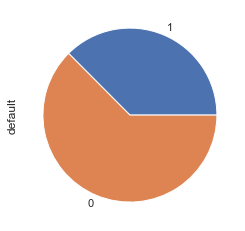

In [301]:
# Df after modeling
sample_submission['default'].value_counts(ascending=True).plot(kind='pie'),


# KULULU - our model real works and effective